<style>
    div.input_prompt {display:none;}
</style>

In [1]:
import os
import requests
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

from opensea import OpenseaAPI

plt.style.use('fivethirtyeight')

In [2]:
def load_environment_variables():
    # Load environment variables from the .env file.
    cwd = os.getcwd()
    env_file_path = os.path.join(cwd, '.env')
    load_dotenv(env_file_path)

    return {
        'api_key': os.environ['OPENSEA_API_KEY'],
        'wallet_address': os.environ['WALLET_ADDRESS']
    }

In [3]:
def fetch_owner_collections(api, owner_address):
    #Fetch the collection data for the owner's wallet address.
    collections = api.collections(asset_owner=owner_address)

    owner_stats = []
    for collection in collections:
        try:
            floor_price = api.collection_stats(collection['slug'])['stats'].get('floor_price', 'Not available')
        except KeyError:
            floor_price = 'Not available'

        collection_stats = {
            "name": collection['name'],
            "slug": collection['slug'],
            "owned_asset_count": collection['owned_asset_count'],
            "floor_price": floor_price
        }
        owner_stats.append(collection_stats)

    return owner_stats

In [4]:
def create_dataframe(owner_stats):
    # Create a DataFrame from the owner's collection statistics.
    df = pd.DataFrame(owner_stats, columns=[
        'name',
        'owned_asset_count',
        'floor_price'
    ])

    df.columns = [
        'Collection Name',
        'Number of Owned NFTs',
        'Floor Price'
    ]

    return df

In [5]:
def filter_dataframe(df):
    # Filter the DataFrame to remove collections with unavailable or very low floor prices.
    df_filtered = df[(df['Floor Price'] != 'Not available') & pd.notna(df['Floor Price'])].copy()
    df_remove_dust = df_filtered[(df_filtered['Floor Price'].astype(float) >= 0.003)].copy()

    return df_remove_dust

In [6]:
def calculate_total_value(df):
    # Calculate the total value of NFTs in the wallet by multiplying the number of owned NFTs by the floor price.
    df['Total Value'] = df['Number of Owned NFTs'] * df['Floor Price']
    total_value_wallet = df['Total Value'].sum()

    return total_value_wallet

In [7]:
def get_color(floor_price):
    #  Determine the color of the bar based on the floor price.
    return (
        'green' if floor_price >= 1 else
        'blue' if floor_price >= 0.5 else
        'red' if floor_price < 0.05 else
        'orange' if floor_price >= 0.05 and floor_price < 0.1 else
        'grey'
    )


def plot_data(df, total_value_wallet):
    # Plot a bar chart, showing the number of owned NFTs and floor prices per collection.
    df_filtered_sorted = df.sort_values(by='Floor Price', ascending=False)

    collection_names_sorted = df_filtered_sorted['Collection Name']
    nft_counts_sorted = df_filtered_sorted['Number of Owned NFTs']
    floor_prices_sorted = df_filtered_sorted['Floor Price']

    colors = list(map(lambda fp: get_color(fp), floor_prices_sorted))

    fig, ax = plt.subplots(figsize=(29, 29))
    bars = ax.barh(collection_names_sorted, nft_counts_sorted, color=colors)

    for i, bar in enumerate(bars):
        floor_price = floor_prices_sorted.iloc[i]
        total_value = df_filtered_sorted['Total Value'].iloc[i]

        if not pd.isna(floor_price):
            ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
                    f"Floor: {floor_price:.4f}\nTotal Value: {total_value:.4f}", ha='left', va='center')

    ax.set_xlabel('Number of Owned NFTs', fontsize=24)
    ax.set_ylabel('Collections', fontsize=24)
    ax.set_title(f'Number of Owned NFTs and Floor Prices per Collection\nTotal value of NFTs in this wallet: {total_value_wallet:.6f}', fontsize=34)
    plt.xticks(rotation=45, ha='right')

    plt.subplots_adjust(left=0.25)
    plt.tight_layout()
    plt.show()

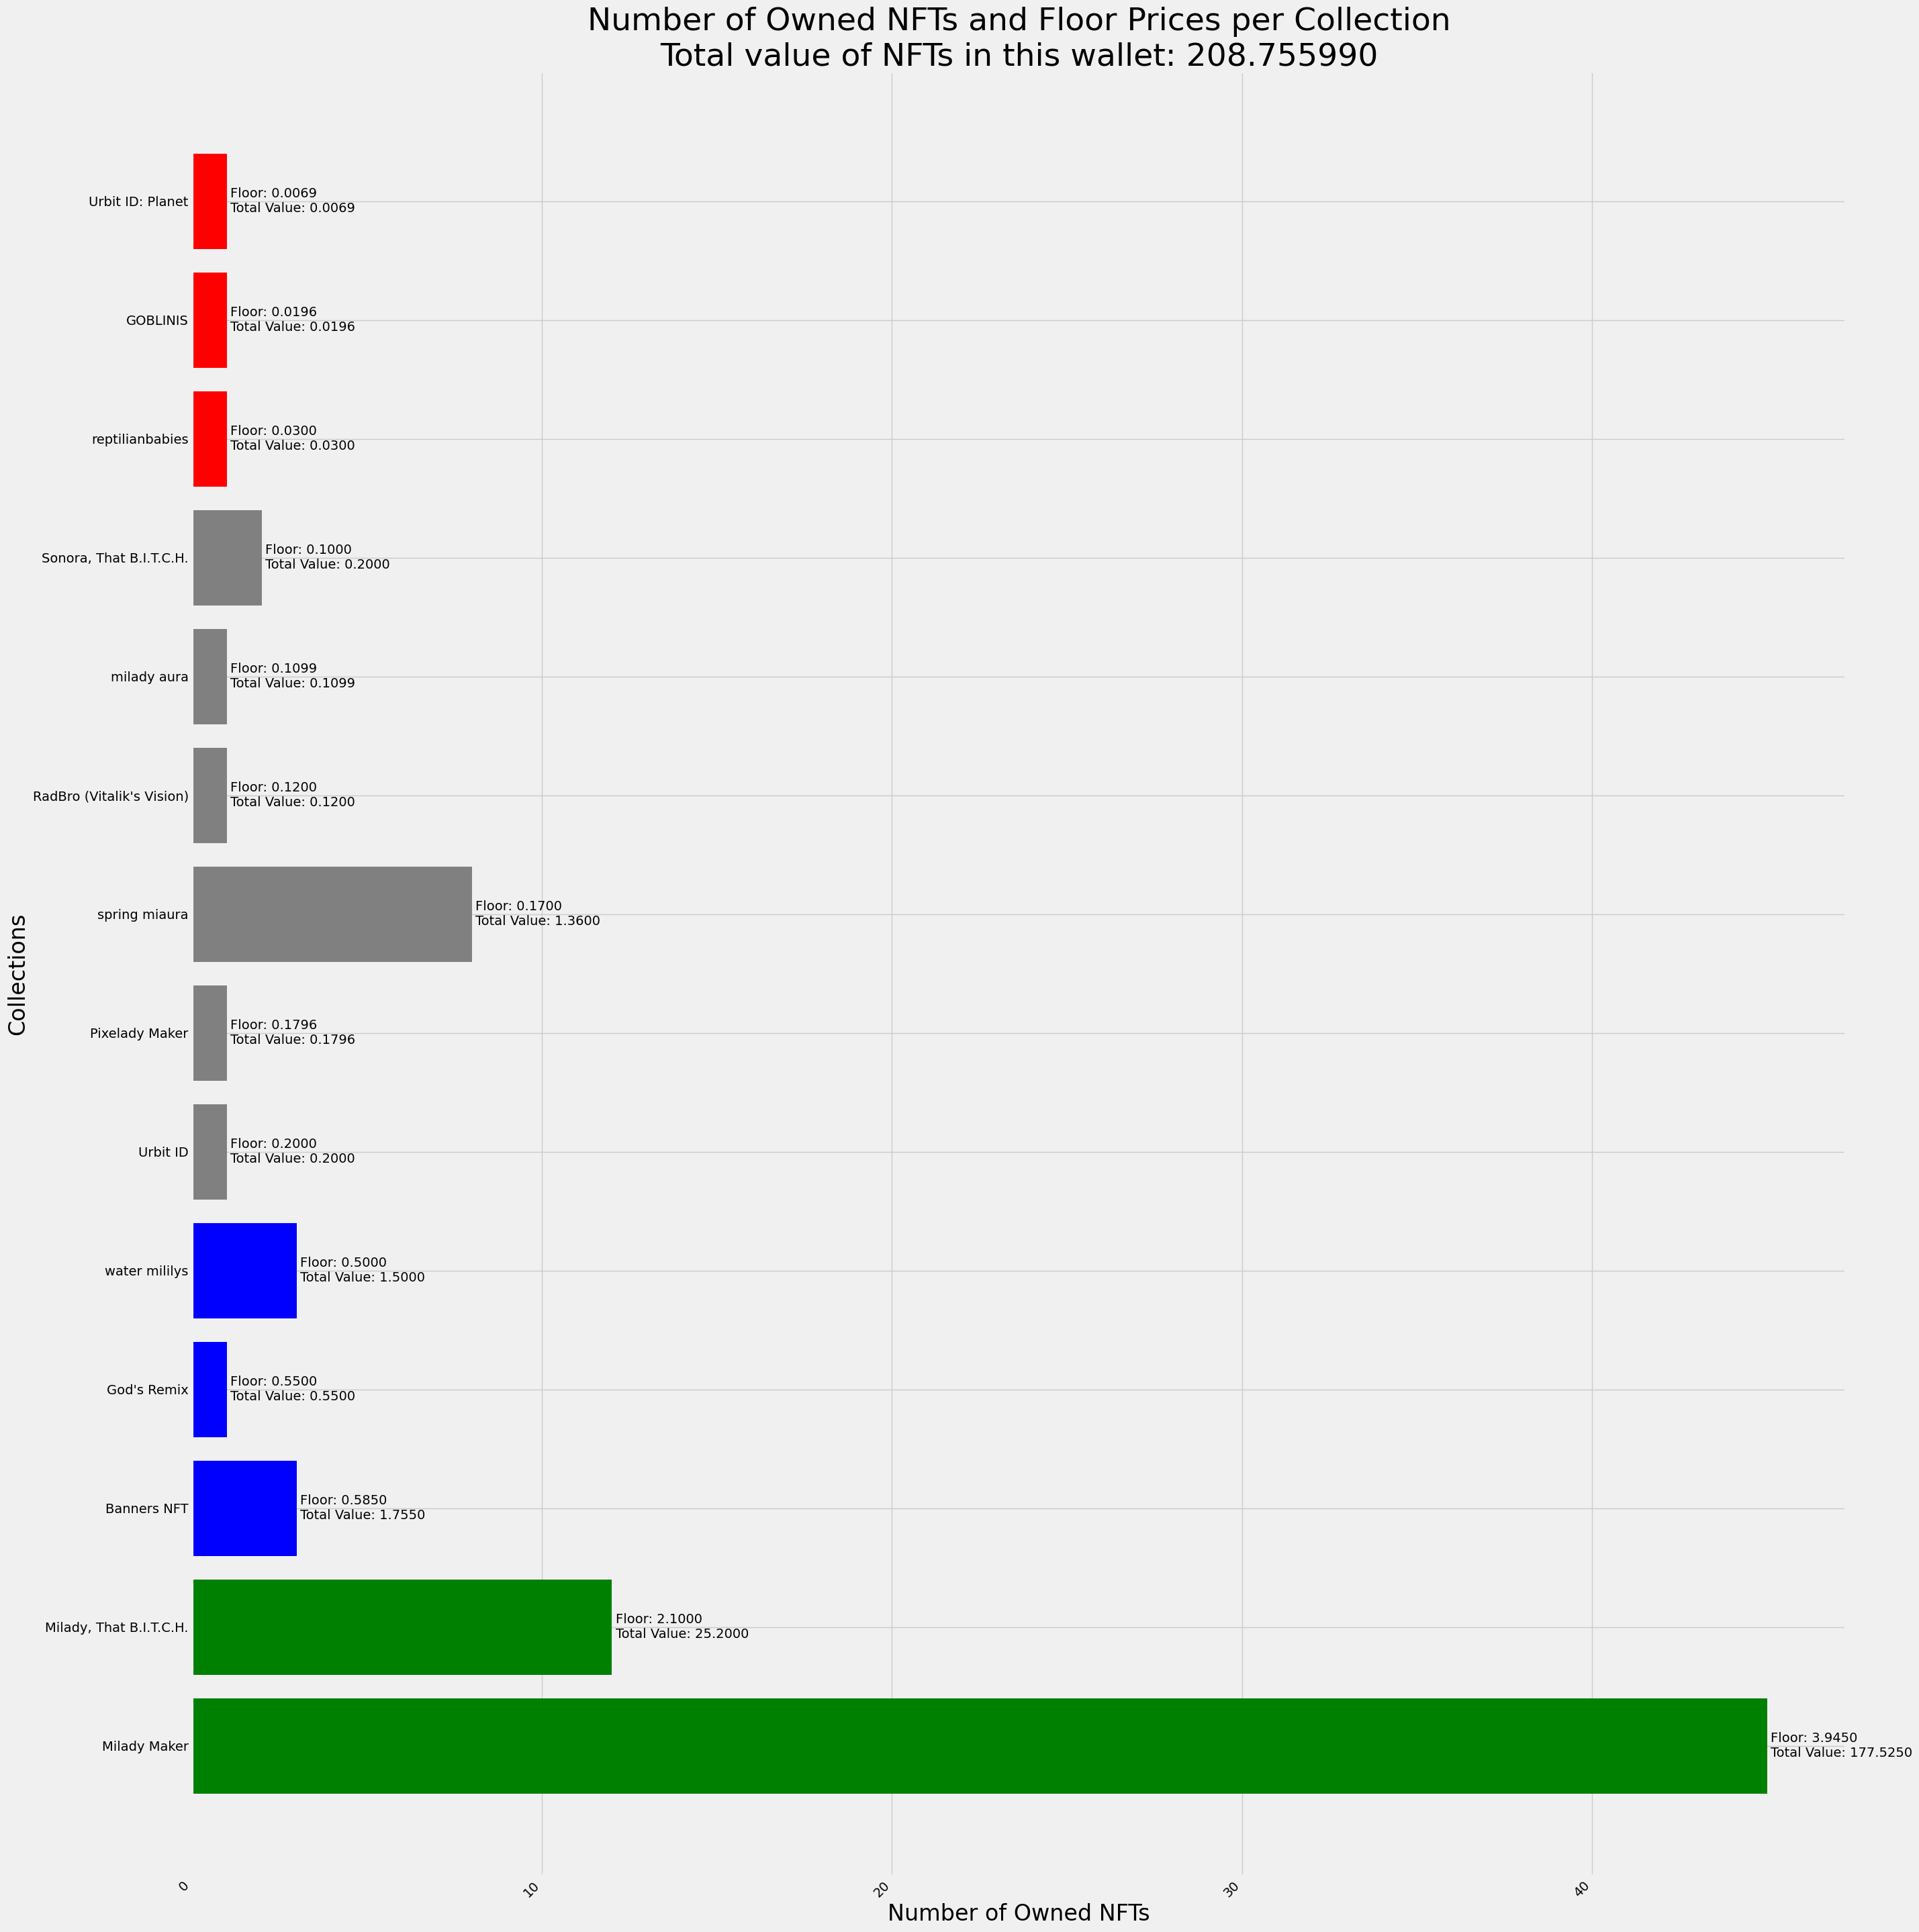

In [8]:
if __name__ == "__main__":
    env_vars = load_environment_variables()
    api = OpenseaAPI(apikey=env_vars['api_key'])
    wallet_address = env_vars['wallet_address']

    owner_stats = fetch_owner_collections(api, wallet_address)
    df = create_dataframe(owner_stats)
    df_filtered = filter_dataframe(df)
    total_value_wallet = calculate_total_value(df_filtered)

    plot_data(df_filtered, total_value_wallet)